# Dependencies

In [6]:
import random
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [7]:
score_dict = []
loss_acc = []

# Initial training

To streamline the training process, the turtle graphics module **was not** utilized in this notebook. Instead, the game was turned into a more 'virtual' version of itself. In this version, the agent moves in a grid the same size as the window in the turtle graphics, and the movements cannot be seen.

I set up different rewards to get the agent to understand better what actions it needed to replicate. There are a total of three rewards.
* one to eat the food, when the agent is on top of the food,
* one to be in the tile next to the food, where 1 or 2 move could get it to eat the food,
* one to be in the same x or y axis as the food.

During this training, the agent was punished for going outside the game boundaries and for not eating any food for too many game iterations.

## Classes

### Game class

In [24]:
class AIgame_noturtle:
    def __init__(self): 
        self.reset()

    def reset(self):
        # the agent (player) consists of x and y coordinates
        self.player = [0, 0, 0] # third element is the direction
        self._move_food()
        self.game_iter = 0
        self.score = 0

    # checks if the agent is outside the game boundaries
    def out_of_bounds(self, x, y):
        if x > 325 or x < -325 or y > 325 or y < -325:
            return True
        else:
            return False

    # randomly moves food around the game field
    def _move_food(self):
        case = random.randint(0, 4)
        if case == 0:
            x = random.randrange(160, 321, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 1:
            x = random.randrange(-320, -159, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 2:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(160, 321, 40)
        else:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(-320, -159, 40)
        self.food = (x, y)

    def play_step(self, action, iter_n):
        # adds a game iteration with each move
        self.game_iter += 1
        
        # moves agent's body
        self._move(action) 
        
        # agent coordinates
        x = self.player[0]
        y = self.player[1]

        # food coordinates
        X = self.food[0]
        Y = self.food[1]

        # exploration reward
        reward = 0
        game_over = False

        # check if the agent is in the game field 
        if self.out_of_bounds(x, y) or self.game_iter > iter_n: # max n of moves without nothing happening before game_over is triggered
            game_over = True
            reward = -20
            return reward, game_over, self.score

        # tier 1 area - agent eats food
        if X == x and Y == y:
            self.score += 1
            reward = 20
            self.game_iter = 0
            self._move_food()
        
        # tier 2 area - agent is 1 block next to food
        if X-42<x<X+42 and Y-42<y<Y+42: # 82
            reward = 10

        # axis area - agent finds itself on the same x or y axis as the food
        if Y == y or X == x:
            reward = 5
        
        return reward, game_over, self.score

    # move player left, right or straight
    def _move(self, action):
        if np.array_equal(action, [0, 1, 0]): # turn right
            if self.player[-1] == 0: # the agent is going up
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1
            elif self.player[-1] == 1: # the agent is going right
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2
            elif self.player[-1] == 2: # the agent is going down
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3 # going left
            else: # the agent is going left
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0 # going up


        elif np.array_equal(action, [0, 0, 1]): # turn left
            if self.player[-1] == 0: # the agent is going up
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3
            elif self.player[-1] == 1: # the agent is going right
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0
            elif self.player[-1] == 2: # the agent is going down
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1 # going right
            else: # the agent is going left
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2 # going down


        elif np.array_equal(action, [1, 0, 0]): # go straight
            if self.player[-1] == 0: # the agent is going up
                self.player[1] = self.player[1] + 40
            elif self.player[-1] == 1: # the agent is going right
                self.player[0] = self.player[0] + 40
            elif self.player[-1] == 2: # the agent is going down
                self.player[1] = self.player[1] - 40
            else: # the agent is going left
                self.player[0] = self.player[0] - 40

### Model class

In [10]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # connects the 2 linear layers with a ReLU function
        return self.linear2(F.relu(self.linear1(x)))

class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        # Mean Squared Error as loss function
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        # unsqueeze the tensors to add a batch size if necessary
        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # predicted Q values with current state
        pred = self.model(state)

        # enstablish target for the current state
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
            
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()
        self.optimizer.step()
        return loss

### Agent class

In [12]:
MAX_MEMORY = 100_000 # actions, state, reward, next state, memory size
BATCH_SIZE = 1000 

class Agent_NT:
    def __init__(self, lr, hidden_u, gamma):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = gamma # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) 
        torch.manual_seed(37) # initialize each new model with the same random weights
        self.model = Linear_QNet(13, hidden_u, 3)
        self.trainer = QTrainer(self.model, lr=lr, gamma=self.gamma)


    def get_state(self, game):
        # gets agent's coordinates and direction
        x = game.player[0]
        y = game.player[1]
        dir = game.player[-1]
        # 0 - Up | 1 - right | 2 - Down | 3 - Left

        state = [
            # Danger straight
            (dir == 0 and game.out_of_bounds(x, y+40)) or 
            (dir == 1 and game.out_of_bounds(x+40, y)) or 
            (dir == 2 and game.out_of_bounds(x, y-40)) or 
            (dir == 3 and game.out_of_bounds(x-40, y)),

            # Danger right
            (dir == 0 and game.out_of_bounds(x+40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y-40)) or 
            (dir == 2 and game.out_of_bounds(x-40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y+40)),

            # Danger left
            (dir == 0 and game.out_of_bounds(x-40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y+40)) or 
            (dir == 2 and game.out_of_bounds(x+40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y-40)),
            
            # Move direction
            dir == 3, # left direction
            dir == 1, # right direction
            dir == 0, # up direction
            dir == 2, # down direction
            
            # Food location 
            game.food[0] < x,  # food left
            game.food[0] > x,  # food right
            game.food[1] > y,  # food up
            game.food[1] < y,  # food down
            game.food[0] == x, # same x axis as food
            game.food[1] == y  # same y axis as food
            ]

        return np.array(state, dtype=int)
    
    # return the model weights, to be called after training completion
    def get_model(self):
        return self.model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        return self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state, epochs):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = int(epochs - epochs/10) - self.n_games
        final_move = [0,0,0]
        if random.randint(0, int(epochs - ((epochs/10) * 2))) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

## Training loop

### Functions

In [121]:
def plot_score(x, record):
    plt.plot(x)
    plt.grid(True)
    plt.xlim(0, len(x))
    if record < 200:
        plt.ylim(0, (record + 5))
    else:
        plt.ylim(0, (record + 500))

In [53]:
def train(epochs, lr, hidden_u, gamma, score_d, loss_l, iterations):
    s_dict = {'score': [],
                'h_score': 0}
    updates = range(0, epochs, int((epochs/10)/2))
    loss = []
    total_score = 0
    record = 0
    agent = Agent_NT(lr, hidden_u, gamma)
    game = AIgame_noturtle()

    while epochs != agent.n_games:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old, epochs)

        # perform move and get new state
        reward, done, score = game.play_step(final_move, iterations)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        # when game over
        if done:
            # train long memory
            loop_loss = agent.train_long_memory()
            loss.append(loop_loss)
            s_dict['score'].append(game.score)
            game.reset()
            agent.n_games += 1

            # update highest score
            if score > record:
                record = score

            # print training updates
            if agent.n_games in updates:
                updated_loss = sum(loss) / len(loss)
                loss_l.append(updated_loss)
                print(f'Epochs: {agent.n_games} | Loss: {updated_loss:.4f} | High score: {record}')

            total_score += score

    updated_loss = sum(loss) / len(loss)
    print(f'Epochs: {epochs} | Loss: {updated_loss:.4f} | High score: {record}')
    s_dict['h_score'] = record
    # appends the dictionary for future data visualization
    score_d.append(s_dict)
    return agent.get_model()

### Model 0

In [54]:
model_0 = train(epochs=600, lr=0.0001, hidden_u=256, gamma=0.6, score_d=score_dict, loss_l=loss_acc, iterations=400)

Epochs: 30 | Loss: 2.8796 | High score: 2
Epochs: 60 | Loss: 2.7841 | High score: 2
Epochs: 90 | Loss: 2.8293 | High score: 2
Epochs: 120 | Loss: 2.8564 | High score: 2
Epochs: 150 | Loss: 2.8855 | High score: 2
Epochs: 180 | Loss: 2.9203 | High score: 3
Epochs: 210 | Loss: 2.9303 | High score: 3
Epochs: 240 | Loss: 2.9529 | High score: 3
Epochs: 270 | Loss: 2.9732 | High score: 4
Epochs: 300 | Loss: 2.9992 | High score: 4
Epochs: 330 | Loss: 3.0304 | High score: 4
Epochs: 360 | Loss: 3.0435 | High score: 5
Epochs: 390 | Loss: 3.0530 | High score: 7
Epochs: 420 | Loss: 3.0781 | High score: 7
Epochs: 450 | Loss: 3.0964 | High score: 11
Epochs: 480 | Loss: 3.1005 | High score: 11
Epochs: 510 | Loss: 3.1153 | High score: 14
Epochs: 540 | Loss: 3.1443 | High score: 14
Epochs: 570 | Loss: 3.1646 | High score: 14
Epochs: 600 | Loss: 3.1945 | High score: 31


Model_0 highest score: 31


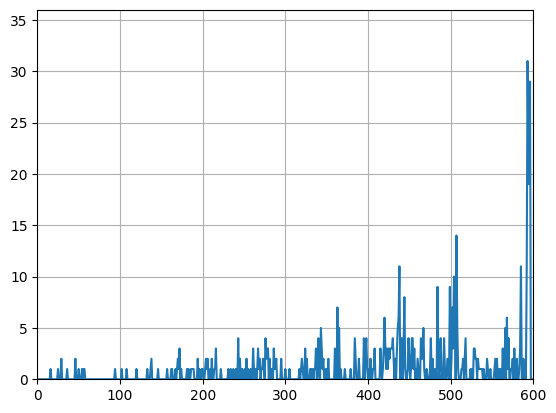

In [59]:
print(f'Model_0 highest score: {score_dict[5]['h_score']}')
plot_score(x=score_dict[5]['score'], record=score_dict[5]['h_score'])

### Model 1

In [57]:
model_1 = train(epochs=600, lr=0.0001, hidden_u=256, gamma=0.6, score_d=score_dict, loss_l=loss_acc, iterations=600)

Epochs: 30 | Loss: 3.1815 | High score: 2
Epochs: 60 | Loss: 3.1712 | High score: 2
Epochs: 90 | Loss: 3.1491 | High score: 2
Epochs: 120 | Loss: 3.1463 | High score: 2
Epochs: 150 | Loss: 3.1572 | High score: 2
Epochs: 180 | Loss: 3.1359 | High score: 2
Epochs: 210 | Loss: 3.1019 | High score: 3
Epochs: 240 | Loss: 3.1245 | High score: 4
Epochs: 270 | Loss: 3.1463 | High score: 4
Epochs: 300 | Loss: 3.1440 | High score: 6
Epochs: 330 | Loss: 3.1373 | High score: 6
Epochs: 360 | Loss: 3.1215 | High score: 6
Epochs: 390 | Loss: 3.1105 | High score: 6
Epochs: 420 | Loss: 3.1121 | High score: 9
Epochs: 450 | Loss: 3.1214 | High score: 9
Epochs: 480 | Loss: 3.1247 | High score: 9
Epochs: 510 | Loss: 3.1325 | High score: 14
Epochs: 540 | Loss: 3.1333 | High score: 14
Epochs: 570 | Loss: 3.1092 | High score: 27
Epochs: 600 | Loss: 3.0711 | High score: 81


Model_1 highest score: 81


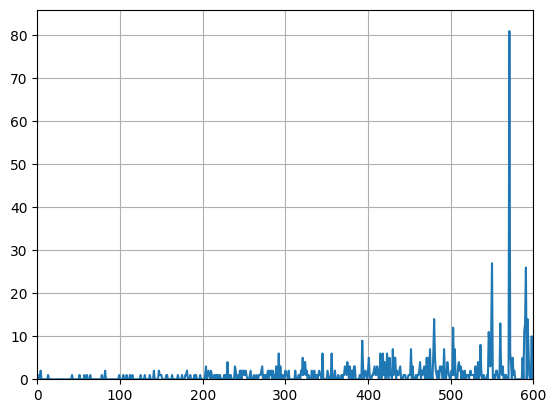

In [61]:
print(f'Model_1 highest score: {score_dict[6]['h_score']}')
plot_score(x=score_dict[6]['score'], record=score_dict[6]['h_score'])

### Model 2

In [29]:
model_2 = train(epochs=800, lr=0.0001, hidden_u=256, gamma=0.6, score_d=score_dict, loss_l=loss_acc, iterations=800)

Epochs: 40 | Loss: 3.3465 | High score: 1
Epochs: 80 | Loss: 3.4510 | High score: 1
Epochs: 120 | Loss: 3.4072 | High score: 2
Epochs: 160 | Loss: 3.3746 | High score: 2
Epochs: 200 | Loss: 3.3511 | High score: 2
Epochs: 240 | Loss: 3.3604 | High score: 2
Epochs: 280 | Loss: 3.3670 | High score: 2
Epochs: 320 | Loss: 3.3549 | High score: 3
Epochs: 360 | Loss: 3.3514 | High score: 4
Epochs: 400 | Loss: 3.3498 | High score: 11
Epochs: 440 | Loss: 3.3475 | High score: 11
Epochs: 480 | Loss: 3.3339 | High score: 11
Epochs: 520 | Loss: 3.3263 | High score: 12
Epochs: 560 | Loss: 3.3235 | High score: 12
Epochs: 600 | Loss: 3.3117 | High score: 24
Epochs: 640 | Loss: 3.3026 | High score: 24
Epochs: 680 | Loss: 3.2937 | High score: 43
Epochs: 720 | Loss: 3.2713 | High score: 194
Epochs: 760 | Loss: 3.2046 | High score: 337877
Epochs: 800 | Loss: 3.1250 | High score: 337877


Model_2 highest score: 337877


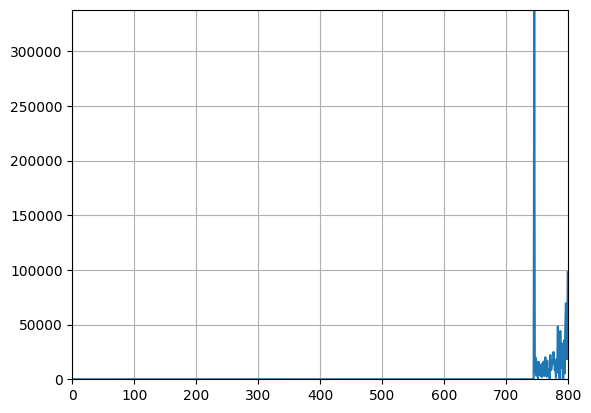

In [62]:
print(f'Model_2 highest score: {score_dict[2]['h_score']}')
plot_score(x=score_dict[2]['score'], record=score_dict[2]['h_score'])

## Saving the best model

This model performance will be tested with a python script using **Turtle graphics**

In [33]:
save_directory = 'model'

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

In [35]:
save_path = os.path.join(save_directory, 'killer_model.pth')
torch.save(model_2.state_dict(), save_path)

### Evaluating the best model

After testing `Model_2` with the Turtle graphics, it was clear that the agent learned well the goal of the game. Although, it would occasionally trap itself in an endless loop. This would occur always in the same positions. Seeing this issue, it was clear that the model required some finetuning.

**Model results in turtle environment**

Game 01/10: score - 933/5000  
Game 02/10: score - 2108/5000  
Game 03/10: score - 5000/5000  
Game 04/10: score - 738/5000  
Game 05/10: score - 3476/5000  
Game 06/10: score - 2565/5000  
Game 07/10: score - 1444/5000  
Game 08/10: score - 505/5000  
Game 09/10: score - 4682/5000  
Game 10/10: score - 5000/5000

# Finetuning

Three different methods were used to try and solve this issue:

* The first one kept all the rewards the same
* The second one penalized one loop the agent got stuck on, and kept the reward for eating the food and being on the same axis as the food
* The last one penalized two types of loop that the agent struggled with, one where the agent would keep running in circle at the corner of the screen, and another one where the agent would keep circumnavigating the food instead of eating it. The food and the axis reward stayed the same.

To finetune the agent, the third method was used, since it yielded the best results. During finetuning, if the agent would perform the same action 15 times in a row (such as turning right or left constantly) it would receive a penalty of **-5**. This action replication would be checked at each `play_step`, meaning that the negative reward would stack quickly when the agent got stuck in the loop.  

During the finetuning, the epsilon value was completely taken out, making use of 100% exploitation.

## Classes

**Main changes**  
* Agent class: fully exploits the previously trained model, no more exploration
* Game class: the 2 loops the agents gets stuck are rewarded negatively, the tier 2 reward area was removed.

### Agent class

In [48]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000 

class Agent_finetune:
    def __init__(self, lr, hidden_u, gamma):
        self.n_games = 0
        # the epsilon value is removed for finetuning
        self.gamma = gamma # discount rate
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Linear_QNet(13, hidden_u, 3)
        # load the saved best model
        self.model.load_state_dict(torch.load(f='model/killer_model.pth'))
        self.trainer = QTrainer(self.model, lr=lr, gamma=self.gamma)


    def get_state(self, game):
        x = game.player[0]
        y = game.player[1]
        dir = game.player[-1]

        state = [
            # Danger straight
            (dir == 0 and game.out_of_bounds(x, y+40)) or 
            (dir == 1 and game.out_of_bounds(x+40, y)) or 
            (dir == 2 and game.out_of_bounds(x, y-40)) or 
            (dir == 3 and game.out_of_bounds(x-40, y)),

            # Danger right
            (dir == 0 and game.out_of_bounds(x+40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y-40)) or 
            (dir == 2 and game.out_of_bounds(x-40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y+40)),

            # Danger left
            (dir == 0 and game.out_of_bounds(x-40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y+40)) or 
            (dir == 2 and game.out_of_bounds(x+40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y-40)),
            
            # Move direction
            dir == 3, # dir_l,
            dir == 1, # dir_r,
            dir == 0, # dir_u,
            dir == 2, # dir_d,
            
            # Food location 
            game.food[0] < x,  
            game.food[0] > x,  
            game.food[1] > y,  
            game.food[1] < y,  
            game.food[0] == x,
            game.food[1] == y
            ]

        return np.array(state, dtype=int)
    
    def get_model(self):
        return self.model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) 

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) 
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        return self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        final_move = [0,0,0]
        state0 = torch.tensor(state, dtype=torch.float)
        prediction = self.model(state0)
        move = torch.argmax(prediction).item()
        final_move[move] = 1

        return final_move

### Game class

In [111]:
class AIgame_finetune:
    def __init__(self): 
        self.reset()

    def reset(self):
        self.player = [0, 0, 0]
        self._move_food()
        self.game_iter = 0
        self.score = 0

    def out_of_bounds(self, x, y):
        if x > 325 or x < -325 or y > 325 or y < -325:
            return True
        else:
            return False

    def _move_food(self):
        case = random.randint(0, 4)
        if case == 0:
            x = random.randrange(160, 321, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 1:
            x = random.randrange(-320, -159, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 2:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(160, 321, 40)
        else:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(-320, -159, 40)
        self.food = (x, y)

    def play_step(self, action, iter_n, actions_memory):
        self.game_iter += 1
        
        # move agent
        self._move(action)
        
        # agent coor
        x = self.player[0]
        y = self.player[1]
        # food coor
        X = self.food[0]
        Y = self.food[1]

        # exploring reward 
        reward = 0

        # check if agent is out of bounds
        game_over = False
        if self.out_of_bounds(x, y) or self.game_iter > iter_n: # max n of moves without nothing happening before game_over is triggered
            game_over = True
            reward = -30
            return reward, game_over, self.score
        
        # check if agent is stuck in loop 1 and assign negative reward
        if len(actions_memory) > 14:
            count = 0
            for act in actions_memory[-14:]:
                if act == [0, 1, 0] or act == [0, 0, 1]:
                    count += 1
            if count == 15:
                reward -= 5

        # check if agent is stuck in loop 2 and assign negative reward
        if len(actions_memory) > 19:
            count = 0 
            for i in range(10):
                if actions_memory[-20+(i*2)] == [0, 1, 0] and actions_memory[-20+((i*2)+1)] == [1, 0, 0]:
                    count += 1
                if actions_memory[-20+(i*2)] == [1, 0, 0] and actions_memory[-20+((i*2)+1)] == [0, 1, 0]:
                    count += 1
                if actions_memory[-20+(i*2)] == [0, 0, 1] and actions_memory[-20+((i*2)+1)] == [1, 0, 0]:
                    count += 1
                if actions_memory[-20+(i*2)] == [1, 0, 0] and actions_memory[-20+((i*2)+1)] == [0, 0, 1]:
                    count += 1
            if count == 10:
                reward -= 5

        # tier 1 area
        if X == x and Y == y:
            self.score += 1
            reward += 20
            self.game_iter = 0
            self._move_food()

        # axis area
        if Y == y or X == x:
            reward += 2

        # soft cap for max point in one game - this ensures that the agent does not continue to play for an excessively long game
        if self.score == 2500:
            reward += 50
            game_over = True
        
        return reward, game_over, self.score

    # move agent left, right or straight ahead
    def _move(self, action):

        if np.array_equal(action, [0, 1, 0]): # turn right
            if self.player[-1] == 0: # the bot is going up
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1
            elif self.player[-1] == 1: # going right
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2
            elif self.player[-1] == 2: # going down
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3 # going left
            else: # going left
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0 # going up


        elif np.array_equal(action, [0, 0, 1]): # turn left
            if self.player[-1] == 0: # the bot is going up
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3
            elif self.player[-1] == 1: # going right
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0
            elif self.player[-1] == 2: # going down
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1 # going right
            else: # going left
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2 # going down


        elif np.array_equal(action, [1, 0, 0]): # go straight
            if self.player[-1] == 0: # the bot is going up
                self.player[1] = self.player[1] + 40
            elif self.player[-1] == 1: # going right
                self.player[0] = self.player[0] + 40
            elif self.player[-1] == 2: # going down
                self.player[1] = self.player[1] - 40
            else: # going left
                self.player[0] = self.player[0] - 40

## Training

In [112]:
def train_ft_x(epochs, lr, hidden_u, gamma, score_d, loss_l, iterations):
    s_dict = {'score': [],
                'h_score': 0}
    updates = range(0, epochs, int((epochs/10)/2))
    memory = []
    loss = []
    total_score = 0
    record = 0
    agent = Agent_finetune(lr, hidden_u, gamma)
    game = AIgame_finetune()

    while epochs != agent.n_games:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # adds action to actions memory
        memory.append(final_move)

        # perform move and get new state
        reward, done, score = game.play_step(final_move, iterations, memory)

        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            loop_loss = agent.train_long_memory()
            loss.append(loop_loss)
            s_dict['score'].append(game.score)
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score

            if agent.n_games in updates:
                updated_loss = sum(loss) / len(loss)
                loss_l.append(updated_loss)
                print(f'Epochs: {agent.n_games} | Loss: {updated_loss:.4f} | High score: {record}')

            # plot_scores.append(score)
            total_score += score
    updated_loss = sum(loss) / len(loss)
    print(f'Epochs: {epochs:03} | Loss: {updated_loss:.4f} | High score: {record}')
    s_dict['h_score'] = record
    score_d.append(s_dict)
    return agent.get_model()

In [113]:
ft = train_ft_x(epochs=100, lr=0.0001, hidden_u=256, gamma=0.9, score_d=score_dict, loss_l=loss_acc, iterations=1000)

Epochs: 5 | Loss: 3.4355 | High score: 2500
Epochs: 10 | Loss: 3.6220 | High score: 2500
Epochs: 15 | Loss: 3.7113 | High score: 2500
Epochs: 20 | Loss: 3.6450 | High score: 2500
Epochs: 25 | Loss: 3.6726 | High score: 2500
Epochs: 30 | Loss: 3.7233 | High score: 2500
Epochs: 35 | Loss: 3.7207 | High score: 2500
Epochs: 40 | Loss: 3.7114 | High score: 2500
Epochs: 45 | Loss: 3.7034 | High score: 2500
Epochs: 50 | Loss: 3.7289 | High score: 2500
Epochs: 55 | Loss: 3.7413 | High score: 2500
Epochs: 60 | Loss: 3.7382 | High score: 2500
Epochs: 65 | Loss: 3.7374 | High score: 2500
Epochs: 70 | Loss: 3.7440 | High score: 2500
Epochs: 75 | Loss: 3.7445 | High score: 2500
Epochs: 80 | Loss: 3.7444 | High score: 2500
Epochs: 85 | Loss: 3.7383 | High score: 2500
Epochs: 90 | Loss: 3.7306 | High score: 2500
Epochs: 95 | Loss: 3.7253 | High score: 2500
Epochs: 100 | Loss: 3.7276 | High score: 2500


Fine tuned model highest score: 2500


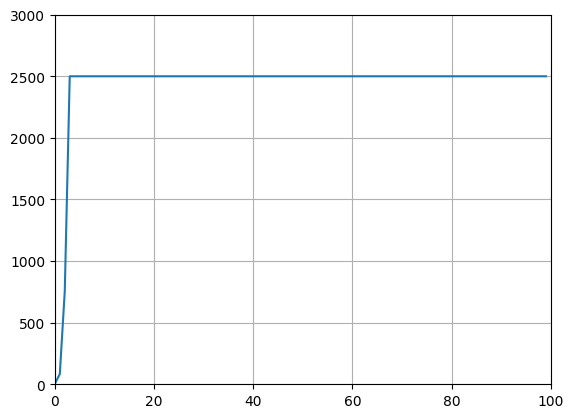

In [122]:
plot_score(x=score_dict[9]['score'], record=score_dict[9]['h_score'])
print(f'Fine tuned model highest score: {score_dict[9]['h_score']}')

## Saving the new best model

In [119]:
save_path = os.path.join(save_directory, 'ft3_0.pth')
torch.save(ft.state_dict(), save_path)

# Testing

## Classes

In [96]:
class AIgame_test:
    def __init__(self): 
        self.reset()

    def reset(self):
        self.player = [0, 0, 0]
        self._move_food()
        self.game_iter = 0
        self.score = 0

    def out_of_bounds(self, x, y):
        if x > 325 or x < -325 or y > 325 or y < -325:
            return True
        else:
            return False

    def _move_food(self):
        case = random.randint(0, 4)
        if case == 0:
            x = random.randrange(160, 321, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 1:
            x = random.randrange(-320, -159, 40)
            y = random.randrange(-320, 321, 40)
        elif case == 2:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(160, 321, 40)
        else:
            x = random.randrange(-320, 321, 40)
            y = random.randrange(-320, -159, 40)
        self.food = (x, y)

    def play_step(self, action, iter_n, rec):
        self.game_iter += 1
        
        # move agent
        self._move(action)
        
        # agent coor
        x = self.player[0]
        y = self.player[1]
        # food coor
        X = self.food[0]
        Y = self.food[1]

        # check if agent is out of bounds
        game_over = False
        if self.out_of_bounds(x, y) or self.game_iter > iter_n: # max n of moves without nothing happening before game_over is triggered
            game_over = True
            return game_over, self.score

        # tier 1 area
        if X == x and Y == y:
            self.score += 1
            self.game_iter = 0
            self._move_food()

        # soft cap for max point in one game - this ensures that the agent does not continue to play for an excessively long game
        if self.score == rec:
            game_over = True
        
        return game_over, self.score

    # move player left, right or straight ahead
    def _move(self, action):

        if np.array_equal(action, [0, 1, 0]): # turn right
            if self.player[-1] == 0: # the bot is going up
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1
            elif self.player[-1] == 1: # going right
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2
            elif self.player[-1] == 2: # going down
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3 # going left
            else: # going left
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0 # going up


        elif np.array_equal(action, [0, 0, 1]): # turn left
            if self.player[-1] == 0: # the bot is going up
                self.player[0] = self.player[0] - 40
                self.player[-1] = 3
            elif self.player[-1] == 1: # going right
                self.player[1] = self.player[1] + 40
                self.player[-1] = 0
            elif self.player[-1] == 2: # going down
                self.player[0] = self.player[0] + 40
                self.player[-1] = 1 # going right
            else: # going left
                self.player[1] = self.player[1] - 40
                self.player[-1] = 2 # going down


        elif np.array_equal(action, [1, 0, 0]): # go straight
            if self.player[-1] == 0: # the bot is going up
                self.player[1] = self.player[1] + 40
            elif self.player[-1] == 1: # going right
                self.player[0] = self.player[0] + 40
            elif self.player[-1] == 2: # going down
                self.player[1] = self.player[1] - 40
            else: # going left
                self.player[0] = self.player[0] - 40

In [123]:
class Agent:
    def __init__(self, hidden_u):
        self.n_games = 0
        self.model = Linear_QNet(13, hidden_u, 3)
        self.model.load_state_dict(torch.load(f='model/ft3_0.pth'))


    def get_state(self, game):
        x = game.player[0]
        y = game.player[1]
        dir = game.player[-1]

        state = [
            # Danger straight
            (dir == 0 and game.out_of_bounds(x, y+40)) or 
            (dir == 1 and game.out_of_bounds(x+40, y)) or 
            (dir == 2 and game.out_of_bounds(x, y-40)) or 
            (dir == 3 and game.out_of_bounds(x-40, y)),

            # Danger right
            (dir == 0 and game.out_of_bounds(x+40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y-40)) or 
            (dir == 2 and game.out_of_bounds(x-40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y+40)),

            # Danger left
            (dir == 0 and game.out_of_bounds(x-40, y)) or 
            (dir == 1 and game.out_of_bounds(x, y+40)) or 
            (dir == 2 and game.out_of_bounds(x+40, y)) or 
            (dir == 3 and game.out_of_bounds(x, y-40)),
            
            # Move direction
            dir == 3, # dir_l,
            dir == 1, # dir_r,
            dir == 0, # dir_u,
            dir == 2, # dir_d,
            
            # Food location 
            game.food[0] < x,  
            game.food[0] > x,  
            game.food[1] > y,  
            game.food[1] < y, 
            game.food[0] == x,
            game.food[1] == y
            ]

        return np.array(state, dtype=int)

    def get_action(self, state):
        final_move = [0,0,0]
        state0 = torch.tensor(state, dtype=torch.float)
        prediction = self.model(state0)
        move = torch.argmax(prediction).item()
        final_move[move] = 1

        return final_move

## Testing function

In [101]:
def play(ROUNDS, rec):
    torch.manual_seed(37)
    agent = Agent(256)
    game = AIgame_test()


    while ROUNDS != agent.n_games:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        done, score = game.play_step(final_move, 1000, rec)

        if done:
            agent.n_games += 1
            print(f"Game {agent.n_games:02}/{ROUNDS}: score - {game.score}/{rec}")
            game.reset()

## Results

In [124]:
play(10, 100000)

Game 01/10: score - 100000/100000
Game 02/10: score - 100000/100000
Game 03/10: score - 100000/100000
Game 04/10: score - 100000/100000
Game 05/10: score - 100000/100000
Game 06/10: score - 100000/100000
Game 07/10: score - 100000/100000
Game 08/10: score - 100000/100000
Game 09/10: score - 100000/100000
Game 10/10: score - 100000/100000


Out of 10 virtual games, the agent achieved a score of 100.000 in all of them. Still, in the game with turtle graphics the results were slightly different.  
**Model results with turtle graphics**  

Game 01/10: score - 291/5000  
Game 02/10: score - 2046/5000  
Game 03/10: score - 5000/5000  
Game 04/10: score - 5000/5000  
Game 05/10: score - 5000/5000  
Game 06/10: score - 5000/5000  
Game 07/10: score - 5000/5000  
Game 08/10: score - 5000/5000  
Game 09/10: score - 5000/5000  
Game 10/10: score - 5000/5000  

The results still show a major improvement from the previous model.